## 1- **Installation et importation**

---


In [1]:
!python -m spacy download fr_core_news_sm
#importer le vocabulaire français
import spacy
nlp = spacy.load("fr_core_news_sm")

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


## 2- **Importer les fichiers**

---



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cette étape est réalisée grace à l'iutilisation du drive afin de faciliter l'accès au données.

 ## 3- **Traitement des données**

---



In [3]:
import pandas as pd
#lire les données avec pandas
#data_test = pd.read_csv('/content/drive/MyDrive/Data_M/donnees.txt', sep="\t", header = None, names = ['id','tweet','date','end'])
data = pd.read_fwf('/content/drive/MyDrive/Data_M/donnees.txt')
data.columns = ['twt','nan']
data[['id2','tweet','date','end']] = data.twt.str.split("\t",expand=True)
#print(data['tweet'][0])
#print(data['date'][0])
#print(data['end'][0])
#print(data['nan'][0])
#après vérification ces deux colonnes ne nous sont pas d'une grande utilité elle sont vides

print(data['tweet'].head())


0    https://t.co/Cy7On2h564 Je commence à stream! ...
1                  je veux encore pleins de casquettes
2    "Je me suis trompé et je me tromperai encore"....
3    qu'Allah nous écarte de la mauvaise fréquentation
4                                              Meufff😻
Name: tweet, dtype: object


In [4]:
data.drop(columns=['end', 'nan'], inplace=True)

In [5]:
print(data.shape)

(100001, 4)


In [6]:
#isoler les tweets
s = data['tweet']
print(s)

0         https://t.co/Cy7On2h564 Je commence à stream! ...
1                       je veux encore pleins de casquettes
2         "Je me suis trompé et je me tromperai encore"....
3         qu'Allah nous écarte de la mauvaise fréquentation
4                                                   Meufff😻
                                ...                        
99996     Dites vous qu’ils y a des gens qui disent à le...
99997         Du Dinos pour l’hiver https://t.co/2j1dj19ZIL
99998             mon gars tes bzr t'es pas content tu swip
99999     Oui oui, on a compris votre vision de la démoc...
100000    Appel à manifester pour les 3 ans du mouvement...
Name: tweet, Length: 100001, dtype: object


## 4 - **Preprocessing** 

---



A - **récupérer la liste des stopwords français**

In [10]:
%%time
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
stop_words = list(fr_stop)


CPU times: user 51 µs, sys: 6 µs, total: 57 µs
Wall time: 62 µs


In [11]:
#le nom du fichier contenant la stoplist
stoplist = "/content/drive/MyDrive/Data_M/stopW.txt"

In [12]:
#créer une stopwords en la fusionnant avec celle de spacy
with open(stoplist, "r") as f:
    stopwords = f.read().splitlines()

stopwords.append(x for x in stop_words)

print(len(stopwords))

626


B- **tokenisation nettoyage et lemmatisation de chaque tweets**

In [13]:
import random
#fixer le seed pour les besoins de reproductibilité
random.seed(3)
list_data= data['tweet'].values.tolist()
#on travaille avec un échantillon de 5000 tweets
raw_sample = random.sample(list_data, 5000)
print(raw_sample[3])

Meme si je suis pas très « fan » de Puma , on va pas se laisser vaincre par le Milan AC 😌#TeamOMAllez l’OM 💙⭐️ https://t.co/2BCFKqCVuF


In [14]:
%%time
#transformer les tweets en objet spacy
docs = list(nlp.pipe(raw_sample))

CPU times: user 26.2 s, sys: 245 ms, total: 26.5 s
Wall time: 26.5 s


In [15]:
#tokeniser et lemmatiser l'ensemble des tweets
""" -enlever la ponctuation,
    - enlever les espaces
    -enlever les email
    -enlever les urls
    -enlever les mots de moins de 3 caractères"""
tokenized_lemmatized_texts_brut = [[token.lemma_.lower() for token in doc 
                               if not token.is_punct and not 
                               token.is_space and not 
                               token.like_url and not 
                               token.like_email and 
                               token.tag_!= 'Num' ] for doc in docs]


In [16]:
#Deuxième passe de nettoyage
def clean(msg):
    clean_msg = []
    for word in msg:
        #Supprimer tout ce qui n'est pas des lettres
        clean_word = re.sub(r'\W', '', word)
        #Supprimer les chiffres
        clean_word = re.sub(r'\d', '', clean_word)
        if clean_word not in stopwords and clean_word != '' : # enlever les mots vide
            clean_msg.append(clean_word)
    return clean_msg

In [17]:
len(tokenized_lemmatized_texts_brut)

5000

In [18]:
%%time
import re
tokenized_lemmatized_texts = []

#Nettoyage des tweets
for msg in tokenized_lemmatized_texts_brut:
    tokenized_lemmatized_texts.append(clean(msg)) 

CPU times: user 981 ms, sys: 649 µs, total: 981 ms
Wall time: 980 ms


À voir comment élargir la stopwords afin de garder des mots significatifs(abréviations) largement utilisés sur les réseau sociaux et relatifs à la haine (ex : pd, fdp etc...)

In [ ]:
#vérifier le résultats
#print(tokenized_lemmatized_texts)

In [19]:
cleaned_tweet= list(tokenized_lemmatized_texts)

for i in range(len(cleaned_tweet)):
    cleaned_tweet[i] = ' '.join(cleaned_tweet[i])

## 5 - **Analyse des données**

---



A- **Boxplot : examiner la longueur des tweets**

In [20]:
#Examiner la longueur en caractères de chaque tweet 
data['pre_clean_longueur'] = [len(t) for t in data.tweet]
print(data.pre_clean_longueur)

0         120
1          35
2         100
3          49
4           7
         ... 
99996     204
99997      45
99998      41
99999      52
100000    107
Name: pre_clean_longueur, Length: 100001, dtype: int64


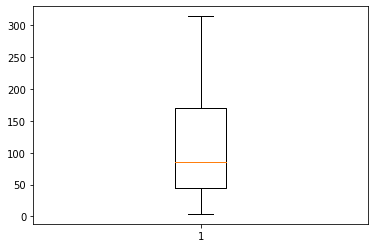

In [21]:
import matplotlib.pyplot as plt 
#Boxplot illustrant la longueur des tweets afin de vérifier s'ils respectent la limite de caractères. 
plt.boxplot(data.pre_clean_longueur)

plt.show()

Les tweets sont de longueurs homogènes , la majorité fluctue entre 40 et 170 caractères avec une moyenne de 80 caractères.

**Remarques:** Ce boxplot m'a permis dans un premier temps de remarquer une erreur dans la lecture et traiment des données départ. En effet, en examinant les longueurs de tweets pour en sortir des tendences de tweets par rapport à leur taille , je me suis rendue compte que certains tweets étaient très longs à un point où ils étaient considérés comme outliers , en cherchant le problème , j'avais remaqrqué que la methode de lecture et de parsing était defectueuse car elle regroupait plusieurs tweets , cette dernière a été remplacée par une autre procédure qui donnent des résultats plus sein et homogènes qui reflêtent la vrai distribution de slongeurs des tweets. 

B- **Nuage de mots : Voir les mots les plus usités dans notre dataset**

In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud

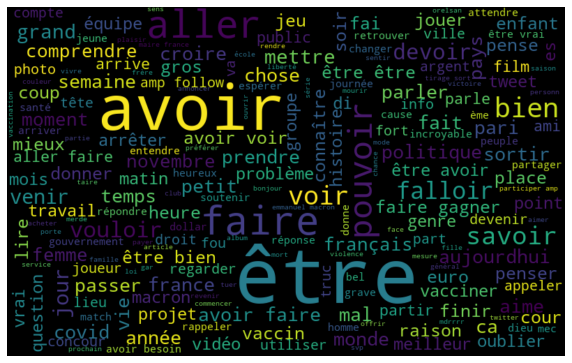

In [23]:
all_words = ' '.join([text for text in cleaned_tweet])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

En prenant le dataset et après nettoyage et preprocessing , on retrouve les verbes être et avoir entre autres verbes très utilisé en français en tête de liste dans le nuage de mots. La question de les supprimmer a été posée , devant le risque de la perte de sens liée à la suppression des verbes d'action . Finalement des derniers ont été gardés.

C- **Diagramme à barres: représentant le nombre d'occurrences des 15 mots les plus utilisés dans nos tweets**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [25]:
import numpy as np

# fonction d'aide
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0] for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])


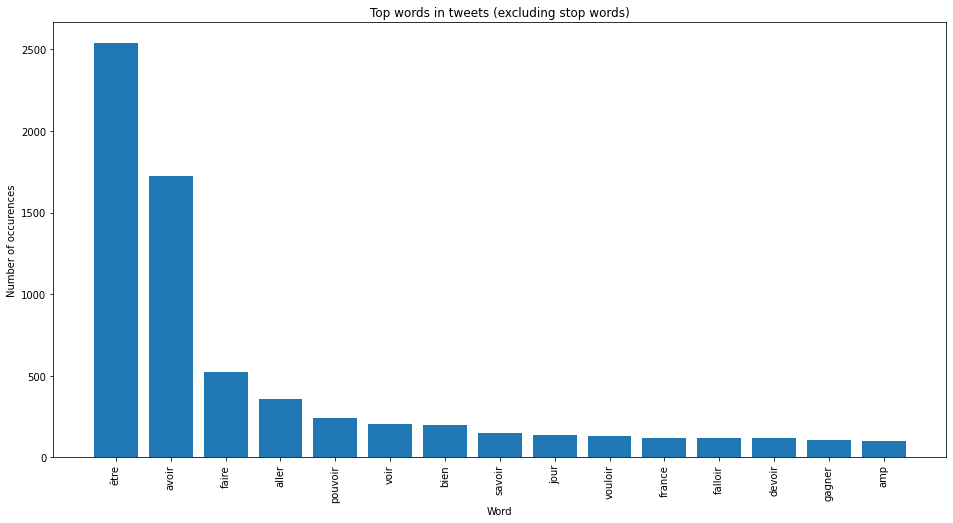

In [26]:
count_vectorizer = CountVectorizer(stop_words=stopwords)

# diagramme à barres représentant le nombre d'occurrences des 15 mots les plus utilisés dans nos tweets
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=cleaned_tweet)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in tweets (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

À l'instar du nuage de mots, on remarque encore la présence en tête de liste des verbes être (dans presque la moitié des tweets  notre échantillon (contenant 5000 tweets), avoir , aller , faire , pouvoir , ce qui conforte notre remarque plus haut avec le nuage de mots .

On retrouve aussi parmi les top mots dans les tweets amp qui pourrait venir de l'encodage HTML &amp après la suppression des caractères spéciaux.

Une deuxième passe de nettoyage était donc necessaire.

**Enregistrement des tweets nettoyés**

In [27]:
# Transformer notre échantillon en dataframe

df = pd.DataFrame(cleaned_tweet,columns =['cleaned_tweet'])
print(df['cleaned_tweet'].head())

0    être avoir culot venir jouer victime méchant g...
1    jslalsbd faisce veu dieuj llook effectvuemy ce...
2                                               unisex
3    meme être fan puma aller vaincre milan ac team...
4                         regarde truc audessus savoir
Name: cleaned_tweet, dtype: object


Les tweets nettoyés ont été transformés en data frame, une structure de données pandas , ressemblant à un tebleau excel et permettant une manipulation rapides et variés  des données.

In [28]:
df.to_pickle('/content/drive/MyDrive/Data_M/clean_data.txt')

Au début du travail j'ai entregistré le dataframe dans dans un fichier , ce qui n'était pas pertinent , un stockage sous format pickle , nous permettrait directement de récupérer la structure de données du dataframe sans relire les données depuis un fichier.